In [1]:
import pandas as pd
from env import get_db_url

import matplotlib.pyplot as plt

import acquire
import wrangle as wr
import exploration as exp

## Acquiring Zillow Data

In [2]:
zillow = acquire.get_zillow_data()
zillow.head()

,Unnamed: 0,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0,10759547,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,1,11193347,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,2,11215747,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,3,11229347,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4,11324547,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


## Checking/Correcting Null Values

In [3]:
# checking total nulls in each column
zillow.isna().sum()

Unnamed: 0                         0
parcelid                           0
bedroomcnt                        11
bathroomcnt                       11
calculatedfinishedsquarefeet    8484
taxvaluedollarcnt                493
yearbuilt                       9337
taxamount                       4442
fips                               0
dtype: int64

In [4]:
# checking number of rows
zillow.shape

(2152863, 9)

In [5]:
# creating proportions to see percentage of nulls in each column
zillow.isna().sum() / zillow.shape[0]

Unnamed: 0                      0.000000
parcelid                        0.000000
bedroomcnt                      0.000005
bathroomcnt                     0.000005
calculatedfinishedsquarefeet    0.003941
taxvaluedollarcnt               0.000229
yearbuilt                       0.004337
taxamount                       0.002063
fips                            0.000000
dtype: float64

### Conclusion: 
> Nulls make up very small percent of data set, I feel comfortable dropping them.

In [6]:
# Drop null values and then compare new df shape 
zillow = zillow.dropna()
zillow = zillow.drop(columns='Unnamed: 0')

# readability
zillow = zillow.rename(columns={'calculatedfinishedsquarefeet': 'sqr_ft'})

zillow.shape[0] / acquire.get_zillow_data().shape[0]

0.9941343225277224

### We still retrain 99.41% of our data with over 2 million rows.

## Checking Data Type Consistency

In [7]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140235 entries, 4 to 2152862
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   parcelid           int64  
 1   bedroomcnt         float64
 2   bathroomcnt        float64
 3   sqr_ft             float64
 4   taxvaluedollarcnt  float64
 5   yearbuilt          float64
 6   taxamount          float64
 7   fips               float64
dtypes: float64(7), int64(1)
memory usage: 147.0 MB


### Conclusion:
> All numeric types are already numeric, although fips and yearbuilt would be better as int64.
Will change yearbuilt to int and fips to int, although fips may be dropped eventually.

In [8]:
cols = ['yearbuilt', 'fips']
zillow[cols] = zillow[cols].astype('int64')
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140235 entries, 4 to 2152862
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   parcelid           int64  
 1   bedroomcnt         float64
 2   bathroomcnt        float64
 3   sqr_ft             float64
 4   taxvaluedollarcnt  float64
 5   yearbuilt          int64  
 6   taxamount          float64
 7   fips               int64  
dtypes: float64(5), int64(3)
memory usage: 147.0 MB


## Analyzing Weird Values in Dataset

In [9]:
# overview description of values
zillow.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,2140235.0,1.304843e+07,4.568911e+06,10711725.00,11656531.50,12596047.00,14053101.50,1.681836e+08
bedroomcnt,2140235.0,3.301419e+00,9.325998e-01,0.00,3.00,3.00,4.00,2.500000e+01
bathroomcnt,2140235.0,2.240352e+00,9.905489e-01,0.00,2.00,2.00,3.00,3.200000e+01
sqr_ft,2140235.0,1.863194e+03,1.221754e+03,1.00,1258.00,1623.00,2208.00,9.525760e+05
taxvaluedollarcnt,2140235.0,4.606416e+05,6.771576e+05,22.00,189166.00,328296.00,534606.00,9.018846e+07
yearbuilt,2140235.0,1.960968e+03,2.215056e+01,1801.00,1949.00,1958.00,1976.00,2.016000e+03
taxamount,2140235.0,5.616711e+03,7.814563e+03,6.34,2540.85,4111.47,6411.93,1.078102e+06
fips,2140235.0,6.048310e+03,2.034491e+01,6037.00,6037.00,6037.00,6059.00,6.111000e+03


# Takeaways:
> * calculatedfinishedsquarefeet should not have a value of 1.00
> * bedroomcnt + bathroomcnt having 0 is weird but not necessarily impossible. Need further research to see how prevalent this is.


## Cleaning Strange Values

https://worldpopulationreview.com/state-rankings/minimum-house-size-by-state

Using this resource, I'm going to limit the data to only include houses with square footage above 70 square feet.

In [10]:
zillow = zillow[zillow.sqr_ft >= 70]
zillow.shape[0] / acquire.get_zillow_data().shape[0]

0.9940888017491127

Using domain knowledge from Andrew's mom, I'm going to drop all bedroom/bathroom counts of 0.

In [11]:
zillow = zillow[zillow.bedroomcnt != 0]
zillow = zillow[zillow.bathroomcnt != 0.0]
zillow.shape[0] / acquire.get_zillow_data().shape[0]

0.9916511176047895

## Takeaway: 

> Still retain 99.1% of data after dropping null values and cleaning zero values for bathroomcnt/bedroomcnt.

In [12]:
zillow = wr.wrangle_zillow()
zillow.head()

(2134889, 8)
(2096851, 8)


,parcelid,bedroomcnt,bathroomcnt,sqr_ft,taxvaluedollarcnt,yearbuilt,taxamount,fips
4,11324547,4.0,2.0,3633.0,296425.0,2005,6941.39,6037
6,11544747,3.0,4.0,1620.0,847770.0,2011,10244.94,6037
7,11585547,3.0,2.0,2077.0,646760.0,1926,7924.68,6037
18,12716947,3.0,1.0,1244.0,169471.0,1950,2532.88,6037
19,12757147,3.0,2.0,1300.0,233266.0,1950,3110.99,6037


In [13]:
zillow.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096831 entries, 4 to 2152862
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   parcelid           2096831 non-null  int64  
 1   bedroomcnt         2096831 non-null  float64
 2   bathroomcnt        2096831 non-null  float64
 3   sqr_ft             2096831 non-null  float64
 4   taxvaluedollarcnt  2096831 non-null  float64
 5   yearbuilt          2096831 non-null  int64  
 6   taxamount          2096831 non-null  float64
 7   fips               2096831 non-null  int64  
dtypes: float64(5), int64(3)
memory usage: 144.0 MB


In [14]:
zillow.fips.value_counts()

6037    1392868
6059     543240
6111     160723
Name: fips, dtype: int64

In [15]:
# identified counties for fips codes 
counties = {'06037': 'los_angeles',
            '06059': 'orange_county',
            '06111': 'ventura'}

## Final Dataset:

In [18]:
zillow.head()

,parcelid,bedroomcnt,bathroomcnt,sqr_ft,taxvaluedollarcnt,yearbuilt,taxamount,fips
4,11324547,4.0,2.0,3633.0,296425.0,2005,6941.39,6037
6,11544747,3.0,4.0,1620.0,847770.0,2011,10244.94,6037
7,11585547,3.0,2.0,2077.0,646760.0,1926,7924.68,6037
18,12716947,3.0,1.0,1244.0,169471.0,1950,2532.88,6037
19,12757147,3.0,2.0,1300.0,233266.0,1950,3110.99,6037


# Proportion of data left after cleaning using following assumptions:
 > * minimum square feet >= 70 ft
 > * minimum square ft calculated also by bthroomcnt * 10 sqr ft 
added to bedroomcnt * 70 sqr ft
 > * all numeric values with z scores over 3.5 taken out

In [19]:
zillow.shape[0] / acquire.get_zillow_data().shape[0]

0.9739732625810374

## Final:
> 97.40% data left after cleaning data / purging extreme values.

## Visualizations of Univariate Distributions

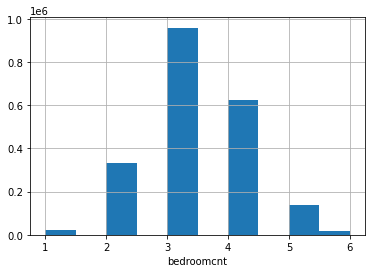

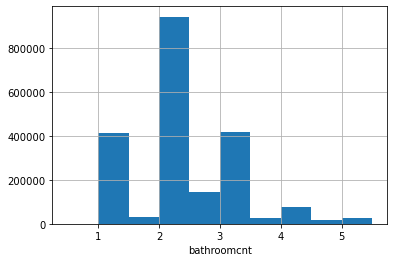

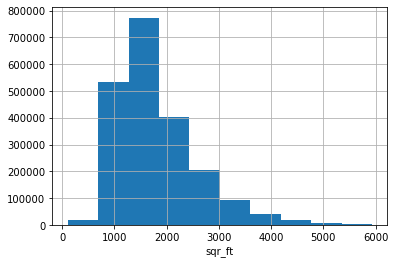

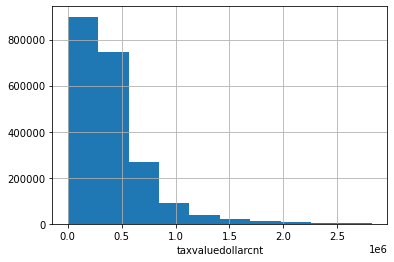

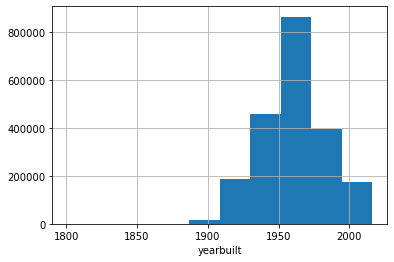

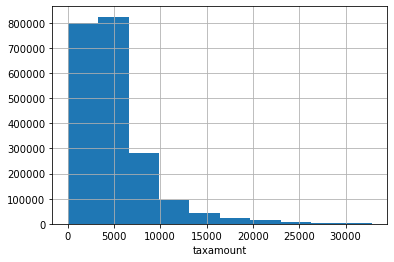

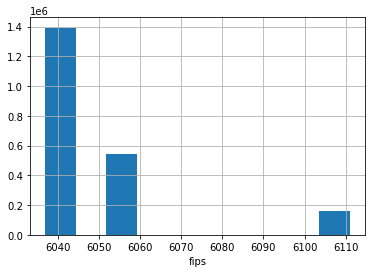

In [17]:
cols_to_visualize = zillow.drop(columns='parcelid').columns
for col in cols_to_visualize:
    exp.target_freq_hist_count(zillow, col)
    plt.xlabel(col)
    plt.show()